[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  4 of 4 completed
NaN in data! Fixed.
[[0.14726591 0.00740369 0.28348061 0.90560406]
 [0.14726591 0.00740369 0.28348061 0.90560406]
 [0.16287018 0.00718103 0.28348061 0.93958657]
 ...
 [0.77007934 0.87085282 0.16723317 0.74721776]
 [0.76770556 0.87096412 0.16723317 0.75616054]
 [0.76770556 0.87096412 0.17036029 0.75616054]]


array([[0.15778525, 0.15778525, 0.15169792, ..., 0.14207663, 0.14276837,
        0.14276837],
       [0.15778525, 0.15169792, 0.15169792, ..., 0.14276837, 0.14276837,
        0.13516649],
       [0.15169792, 0.15169792, 0.14621493, ..., 0.14276837, 0.13516649,
        0.13516649],
       ...,
       [0.79062285, 0.79780486, 0.79780486, ..., 0.75404546, 0.75404546,
        0.77007934],
       [0.79780486, 0.79780486, 0.79073449, ..., 0.75404546, 0.77007934,
        0.77007934],
       [0.79780486, 0.79073449, 0.79073449, ..., 0.77007934, 0.77007934,
        0.76770556]])

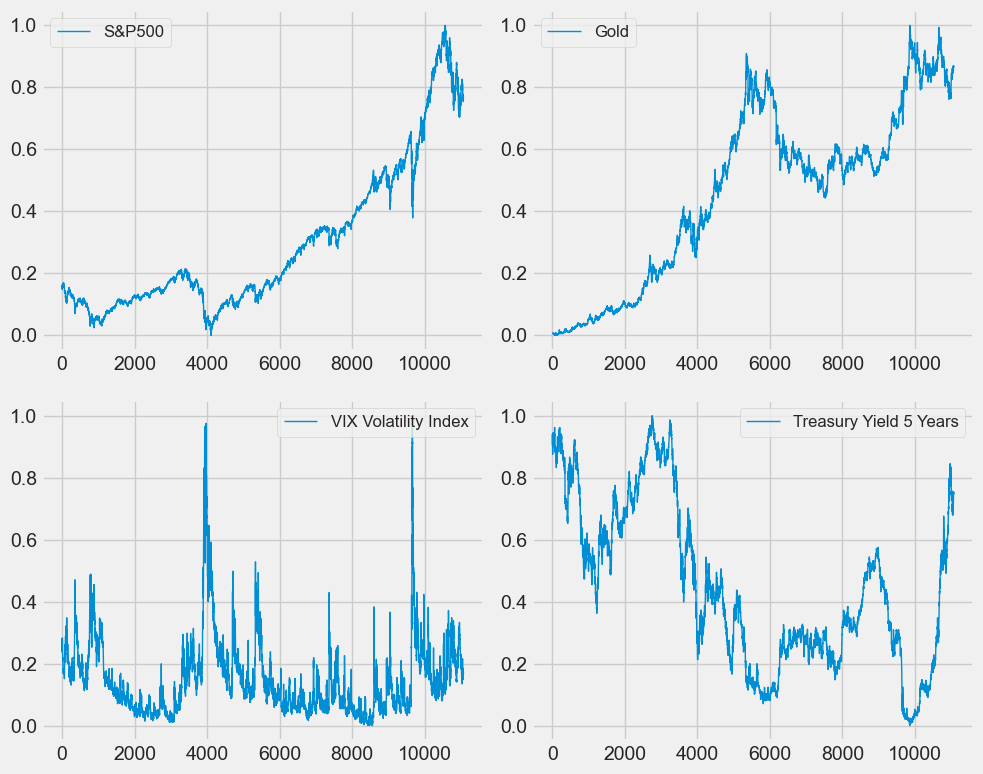

In [28]:
import sys
sys.path.insert(1, r"C:/Users/mihao/OneDrive - Univerza v Ljubljani/Doktorski_studij/Delo/Evolving transformer")
sys.path.insert(1, r"C:\Users\Miha\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\Evolving transformer")
from importlib import reload 
import data.dataclass_module as dataclass_module
reload(dataclass_module)

input_length = 60
output_length = 30
training_part = 0.8
output_steps_ahead = 1
database = dataclass_module.StockData(input_length,output_length,output_steps_ahead)
database.display_data_norm()

#print(database.data_dropped)
print(database.data_norm)

#print(database.datasnp_dropped)
scalar = database.scalar

database.dataset_input
database.dataset_output


In [29]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

'''
class Stockdataset(Dataset):
    def __init__(self, data, input_length, output_length = 1):
        self.data = data
        self.data = torch.from_numpy(data).float()#.view(-1)
        self.seq_len = input_length
        self.out_len = output_length

    def __len__(self):
        return len(self.data)-(self.seq_len+self.out_len+1)

    def __getitem__(self, index):
        return self.data[index : index+self.seq_len], self.data[index+self.seq_len+1: index+self.seq_len+self.out_len+1,0]
'''

size_training = int(len(database.data_norm)*training_part)
size_valid = int((len(database.data_norm) - size_training)/2)
data_train, data_val, data_test = database.data_norm[0:size_training,:], database.data_norm[size_training:(len(database.data_norm)-size_valid),:], database.data_norm[(len(database.data_norm)-size_valid):,:]

print(data_train.shape)
print(data_val.shape)
print(data_test.shape)

train_dataset = dataclass_module.Stockdataset(data_train, input_length, output_length)
valid_dataset = dataclass_module.Stockdataset(data_val, input_length, output_length)
test_dataset = dataclass_module.Stockdataset(data_test, input_length, output_length)
whole_dataset = dataclass_module.Stockdataset(database.data_norm, input_length, output_length)

print(test_dataset.__getitem__(1)[0].shape)
print(train_dataset.__getitem__(1)[0].shape)
print(whole_dataset.__getitem__(0)[0].shape)

training_batch_size = 513; #513
batch_size = training_batch_size
train_dataloader = DataLoader(train_dataset, batch_size, drop_last = True, shuffle=True) #drop_last = True ignores last batch is data is not divisable by batch_size
valid_dataloader = DataLoader(valid_dataset, batch_size, drop_last = True, shuffle=True) #drop_last = True ignores last batch is data is not divisable by batch_size
test_dataloader = DataLoader(test_dataset, batch_size, drop_last = True, shuffle=True)

whole_dataloader = DataLoader(whole_dataset, batch_size, drop_last = True, shuffle=False)
#whole_dataloader = DataLoader(train_dataset, 1, drop_last = False)

# Check if CUDA is available
if torch.cuda.is_available():
    # Get the current selected device
    device = torch.device('cuda')

    # Calculate memory details (in bytes)
    total_memory = torch.cuda.get_device_properties(device).total_memory
    allocated_memory = torch.cuda.memory_allocated(device)
    available_memory = total_memory - allocated_memory

    # Convert bytes to GB
    total_memory_GB = total_memory / (1024 ** 3)
    allocated_memory_GB = allocated_memory / (1024 ** 3)
    available_memory_GB = available_memory / (1024 ** 3)

    print(f"Total memory on GPU: {total_memory_GB} GB")
    print(f"Allocated memory on GPU: {allocated_memory_GB} GB")
    print(f"Available memory on GPU: {available_memory_GB} GB")

    # If available memory is less than 2GB, use CPU
    if available_memory_GB < 2:
        device = torch.device('cpu')

else:
    # If CUDA is not available, use CPU
    device = torch.device('cpu')

print(f"Using device: {device}")



(8858, 4)
(1108, 4)
(1107, 4)
torch.Size([60, 4])
torch.Size([60, 4])
torch.Size([60, 4])
Total memory on GPU: 1.99969482421875 GB
Allocated memory on GPU: 0.0 GB
Available memory on GPU: 1.99969482421875 GB
Using device: cpu


In [30]:
class LSTMSeq2SeqForecastingNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim=1, dropout_rate=0.1):
        super(LSTMSeq2SeqForecastingNetwork, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
        
        # Output layer
        self.fc_out = nn.Linear(hidden_dim, output_dim)

        # Define the dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        # Define the layer normalization
        self.ln = nn.LayerNorm(hidden_dim)

    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)
        
        # Output layer
        y = self.fc_out(lstm_out)

        return y[:, -output_length:]


In [31]:
import torch.optim as optim

# Hyperparameters
input_dim = 4
output_length = output_length
hidden_dim = 128
num_layers = 3
dropout_rate = 0.1
num_epochs = 300

model = LSTMSeq2SeqForecastingNetwork(input_dim, hidden_dim, num_layers, 1, dropout_rate).to(device)
learning_rate = 0.001  # or any other value
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

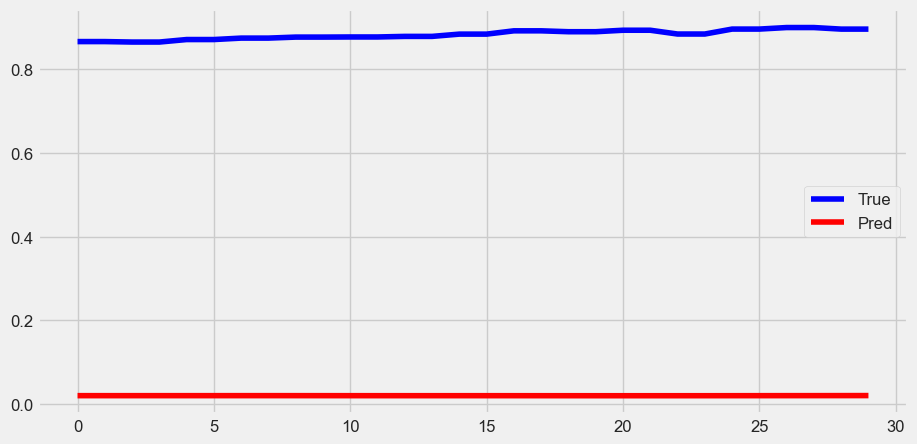

Test Loss: 0.6914
MAE: 0.8631, MSE: 0.7451, RMSE: 0.8632, NRMSE: 79.6455


(0.86311334, 0.7450823, 0.86318153, 79.6455)

In [32]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.metrics import mean_absolute_error, mean_squared_error

def test(dataloader):
    model.eval()
    test_loss = 0
    all_y = []
    all_out = []
    
    # Close all previous figures
    clear_output(wait=True)

    # Create a new figure
    plt.figure(figsize=(10, 5))

    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            x = x.to(device)
            y = y.to(device)
            
            out = model(x)
            test_loss += loss_fn(out, y.unsqueeze(2)).item()

            # For visualization, just take the first sequence in the batch
            y = y[0].cpu().numpy()
            out = out[0].cpu().numpy()

            # Plot the true and predicted sequences with specified colors
            plt.plot(range(len(y)), y, color='blue', label='True' if i == 0 else "")
            plt.plot(range(len(out)), out, color='red', label='Pred' if i == 0 else "")

            # Append the data for MAE, RMSE, MSE, and NRMSE computation
            all_y.append(y)
            all_out.append(out)

    # Show the legend and the plot
    plt.legend()
    plt.show()

    test_loss /= len(dataloader)
    print(f'Test Loss: {test_loss:.4f}')

    # Compute and print MAE, RMSE, MSE, and NRMSE
    all_y = np.concatenate(all_y)
    all_out = np.concatenate(all_out)

    mae = mean_absolute_error(all_y, all_out)
    mse = mean_squared_error(all_y, all_out)
    rmse = np.sqrt(mse)
    nrmse = rmse / np.std(all_y)
    print(f'MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, NRMSE: {nrmse:.4f}')
    return mae, mse, rmse, nrmse

test(test_dataloader)


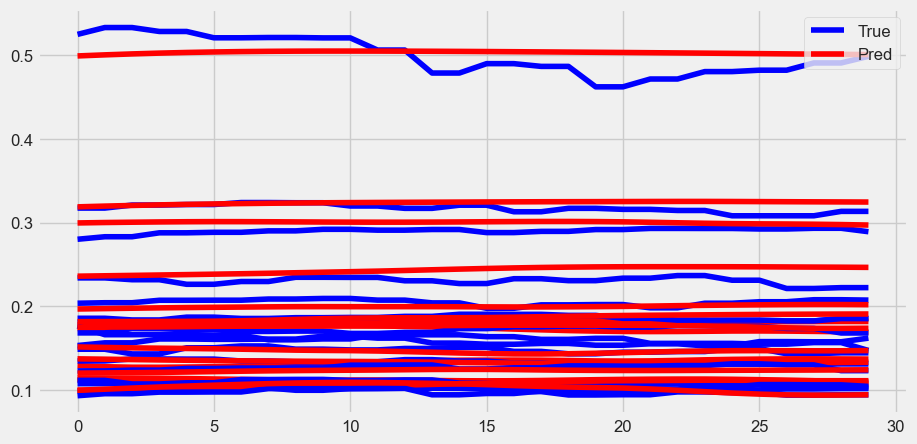

Test Loss: 0.0001
MAE: 0.0084, MSE: 0.0001, RMSE: 0.0106, NRMSE: 0.1068


In [33]:
# Training

MSE_min = 10
for epoch in range(num_epochs):
    loss_sum = 0
    for batch, (x, y) in enumerate(train_dataloader):
        model.train()

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        
        out = model(x)

        loss = loss_fn(out, y.unsqueeze(2))
        loss.backward()
        
        optimizer.step()
        
        loss_sum += loss.item()

    print(f"Epoch {epoch}, training loss: {loss_sum/len(train_dataloader)}")
    if (epoch+1) % 10 == 0:
        mae, mse, rmse, nrmse = test(valid_dataloader)
        if MSE_min > mse:
            MSE_min = mse
            torch.save(model, "model_LSTM.pt")
            print(f' Save MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, NRMSE: {nrmse:.4f}')




In [38]:
model = torch.load("model_LSTM.pt", map_location=torch.device(device))
# Testing
model.eval()
mae_train, mse_train, rmse_train, nrmse_train  = test(train_dataloader)

FileNotFoundError: [Errno 2] No such file or directory: 'model_LSRM.pt'

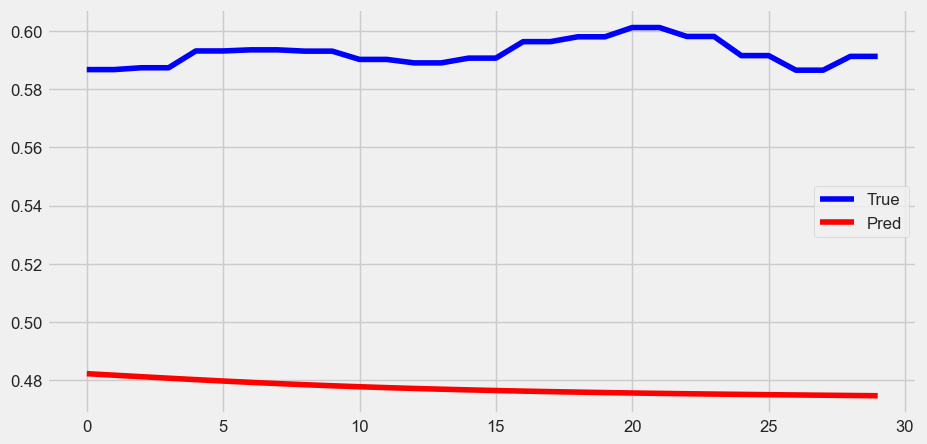

Test Loss: 0.0096
MAE: 0.1153, MSE: 0.0133, RMSE: 0.1155, NRMSE: 27.0923


In [34]:
mae_valid, mse_valid, rmse_valid, nrmse_valid  = test(valid_dataloader)


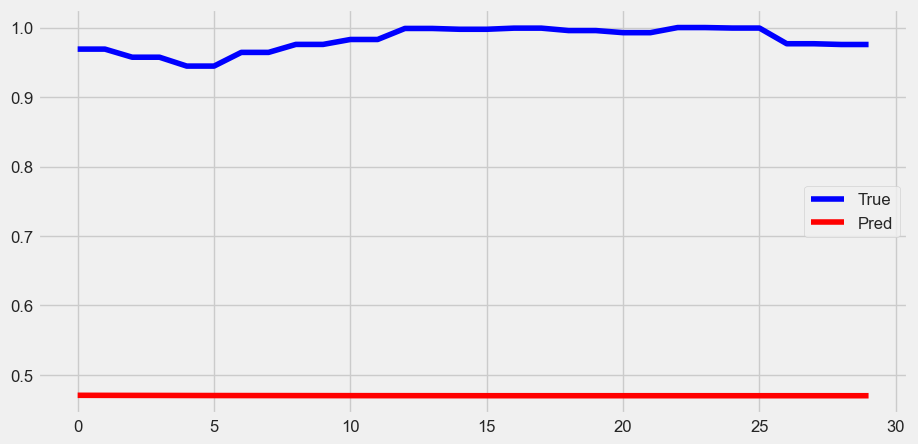

Test Loss: 0.1513
MAE: 0.5117, MSE: 0.2622, RMSE: 0.5120, NRMSE: 30.0864


In [35]:
mae_test, mse_test, rmse_test, nrmse_test  = test(test_dataloader)


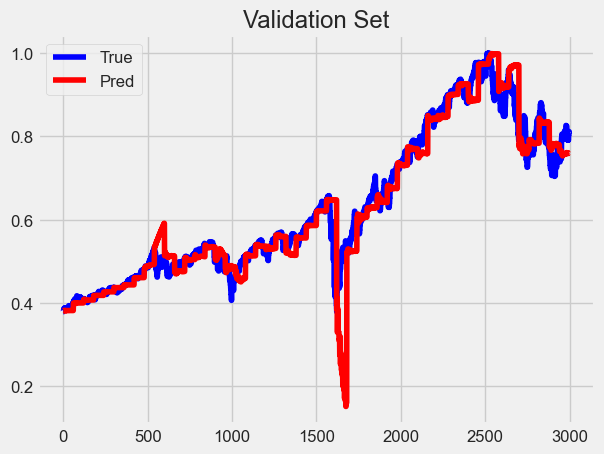

Validation Set - MAE: 0.0284, MSE: 0.0027, RMSE: 0.0516


In [36]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

from IPython.display import clear_output
# Suppress warnings
warnings.filterwarnings("ignore")

# Specify the order (p, d, q) of the ARIMA model
order = (30,1,10)

# Split the data into training and validation sets
size_training = int(len(database.data_norm)*0.70)
size_test = len(database.data_norm) - size_training
data_train, data_val = database.data_norm[0:size_training,0], database.data_norm[size_training:len(database.data_norm),0]

input_length = 300
output_length = 60

def predict_and_evaluate(data, dataset_name):
    predictions = []
    actuals = []
    plt.figure(figsize=(10, 5))

    # Initialize lists to store the training data and forecasts
    training_data_list = []
    forecasts_list = []

    for t in range(input_length, len(data) - output_length, output_length):
        # Create the input sequence
        input_seq = data[t-input_length:t]

        # Define the ARIMA model and fit it to the input sequence
        model = ARIMA(input_seq, order=order)
        model_fit = model.fit()
        
        # Make output_length-step-ahead forecasts
        forecast = model_fit.forecast(steps=output_length)

        # Store the forecasts
        predictions.extend(forecast)
        actuals.extend(data[t:t+output_length])

        # Only save and plot the data every 'input_length' time steps
        if t % output_length == 0:
            # Save the training data and the forecast
            training_data = np.arange(t - input_length, t), data[(t - input_length):t]
            training_data_list.append(training_data)
            forecast_data = np.arange(t, t + output_length), forecast
            forecasts_list.append(forecast_data)

            # Clear the output of the cell
            clear_output(wait=True)
            
            # Plot the training data and forecasts
            for j in range(len(training_data_list)):
                plt.plot(training_data_list[j][0], training_data_list[j][1],'b', label=f'Training Data at t={j*input_length}')
                plt.plot(forecasts_list[j][0], forecasts_list[j][1],'r', label=f'Forecast at t={j*input_length}')

            plt.show()

    # Clear the current figure's content
    plt.clf()
    clear_output(wait=True)
    # Plot the true and predicted sequences
    plt.plot(range(len(actuals)), actuals, color='blue', label='True')
    plt.plot(range(len(predictions)), predictions, color='red', label='Pred')

    # Legend and title
    plt.legend()
    plt.title(dataset_name)
    plt.show()

    # Display the updated plot
    plt.pause(0.01)

    # Compute and print MAE, MSE, RMSE, and NRMSE
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)

    print(f'{dataset_name} - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}')

#predict_and_evaluate(data_train, 'Training Set')
predict_and_evaluate(data_val, 'Validation Set')


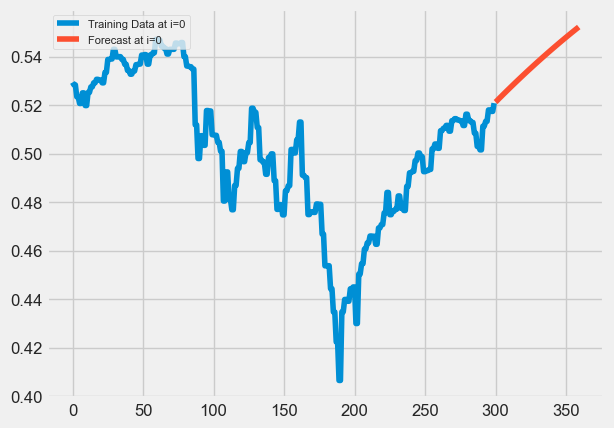

KeyboardInterrupt: 

In [37]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima
from pandas import read_csv
import matplotlib.pyplot as plt
from IPython.display import clear_output

# load the dataset
size_training = int(len(database.data_norm)*training_part)
size_test = len(database.data_norm) - size_training
data_train, data_val = database.data_norm[0:size_training,0], database.data_norm[size_training:len(database.data_norm),0]

# Fit auto_arima function to 'data_train'
model = auto_arima(data_train, start_p = 5, start_q = 1,  start_d = 1, 
                          max_p = 10, max_q = 3,
                          seasonal = False, trace = True,
                          error_action ='ignore',   # don't want to know if an order does not work
                          suppress_warnings = True,  # don't want convergence warnings
                          stepwise = True)           # set to stepwise
model.fit(data_train)

# To print the summary
model.summary()

# Initialize lists to store the training data and forecasts
training_data_list = []
forecasts_list = []

# Generate 'output_length' forecasts at each step of 'data_val', using a rolling window of 'input_length' samples
for i in range(input_length, len(data_val)):
    # Retrain the model with the new window and generate the forecast
    model.update(data_val[(i-input_length):i])
    forecast = model.predict(n_periods=output_length)

    # Only save and plot the data every 'input_length' time steps
    if i % input_length == 0:
        # Save the training data and the forecast
        training_data = np.arange(i - input_length, i), data_val[(i - input_length):i]
        training_data_list.append(training_data)
        forecast_data = np.arange(i, i + output_length), forecast
        forecasts_list.append(forecast_data)

        # Clear the output of the cell
        clear_output(wait=True)
        
        # Plot the training data and forecasts
        for j in range(len(training_data_list)):
            plt.plot(training_data_list[j][0], training_data_list[j][1], label=f'Training Data at i={j*input_length}')
            plt.plot(forecasts_list[j][0], forecasts_list[j][1], label=f'Forecast at i={j*input_length}')

        plt.legend(loc='upper left', fontsize=8)
        plt.show()


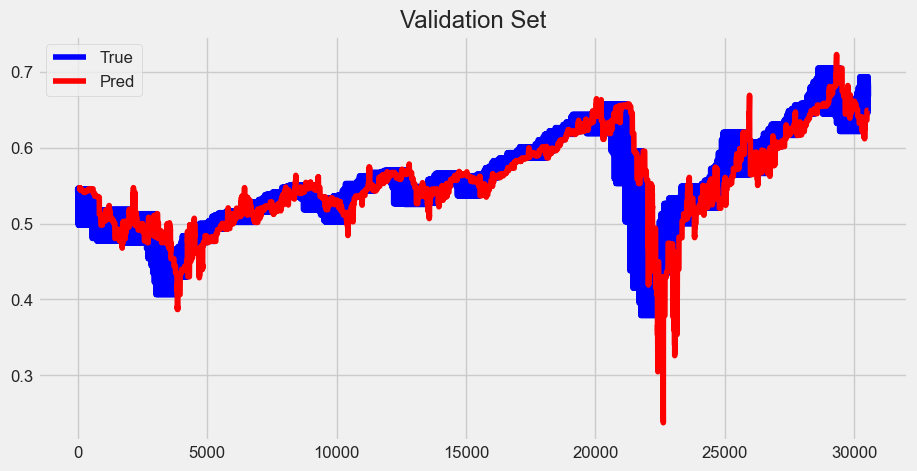

Validation Set - MAE: 0.0190, MSE: 0.0009, RMSE: 0.0299


LinAlgError: LU decomposition error.

<Figure size 1000x500 with 0 Axes>

In [ ]:

from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

from IPython.display import clear_output
# Suppress warnings
warnings.filterwarnings("ignore")

# Specify the order (p, d, q) of the ARIMA model
order = (30,1,1)

# Split the data into training and validation sets
size_training = int(len(database.data_norm)*training_part)

size_valid = int((len(database.data_norm) - size_training)/2)
data_train, data_val, data_test = database.data_norm[0:size_training,0], database.data_norm[size_training:(len(database.data_norm)-size_valid),0], database.data_norm[(len(database.data_norm)-size_valid):,0]

input_length = 60
output_length = 30

def predict_and_evaluate(data, dataset_name):
    predictions = []
    actuals = []
    plt.figure(figsize=(10, 5))

    # Initialize lists to store the training data and forecasts
    training_data_list = []
    forecasts_list = []

    for t in range(input_length, len(data) - output_length):
        # Create the input sequence
        input_seq = data[t-input_length:t]

        # Define the ARIMA model and fit it to the input sequence
        model = ARIMA(input_seq, order=order)
        model.initialize_approximate_diffuse()
        model_fit = model.fit()
        
        # Make output_length-step-ahead forecasts
        forecast = model_fit.forecast(steps=output_length)

        # Store the forecasts
        predictions.extend(forecast)
        actuals.extend(data[t:t+output_length])

        # Only save and plot the data every 'input_length' time steps
        if  (t % output_length == 1000):
                
            # Save the training data and the forecast
            training_data = np.arange(t - input_length, t), data[(t - input_length):t]
            training_data_list.append(training_data)
            forecast_data = np.arange(t, t + output_length), forecast
            forecasts_list.append(forecast_data)

            # Clear the output of the cell
            clear_output(wait=True)
            
            # Plot the training data and forecasts
            for j in range(len(training_data_list)):
                plt.plot(training_data_list[j][0], training_data_list[j][1],'b', label=f'Training Data at t={j*input_length}')
                plt.plot(forecasts_list[j][0], forecasts_list[j][1],'r', label=f'Forecast at t={j*input_length}')

            plt.show()
            # Display the updated plot
            plt.pause(0.01)
            # Compute and print MAE, MSE, RMSE, and NRMSE
            mae = mean_absolute_error(actuals, predictions)
            mse = mean_squared_error(actuals, predictions)
            rmse = np.sqrt(mse)

            print(f'{dataset_name} - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}') 

    # Clear the current figure's content
    plt.clf()
    clear_output(wait=True)
    # Plot the true and predicted sequences
    plt.plot(range(len(actuals)), actuals, color='blue', label='True')
    plt.plot(range(len(predictions)), predictions, color='red', label='Pred')

    # Legend and title
    plt.legend()
    plt.title(dataset_name)
    plt.show()

    # Display the updated plot
    plt.pause(0.01)

    # Compute and print MAE, MSE, RMSE, and NRMSE
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)

    print(f'{dataset_name} - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}')

predict_and_evaluate(data_train, 'Training Set')
predict_and_evaluate(data_val, 'Validation Set')
predict_and_evaluate(data_test, 'Testing Set')